# Script for generating trait + population graphs
Plots each species in one simulation on the same graph (for comparison between species)
Prints each trait from all simulations next to each other (for comparison between different simulations)

In [1]:
export = True

In [2]:
# basic imports and reading of file
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import pandas as pd
import numpy as np
from os import listdir
from os.path import isfile, join
from pathlib import Path
import glob
import time
import json
import seaborn as sns

In [3]:
# load logs
traits = []
fcms = []
dataframes = []
fcm_dataframes = dict()

subFolders = glob.glob("Logs/*/")
for sub in subFolders:
    traits = traits + glob.glob(sub +"Traits.txt")
    fcms = fcms + glob.glob(sub + "*_fcm.txt")
for file in traits:
    dataframes.append((pd.read_csv(file), file.split('\\')[1]))
#for file in fcms:
#    with open(file, 'r') as f:
#        fcm = json.load(f)
#    fcmJsons.append((fcm, file.split('\\')[1], file.split('\\')[2].split('.')[0]))
for file in fcms:
    graph_name = file.split('\\')[1]
    specie = file.split('\\')[2].split('_fcm.')[0].split(' ')[2]
    round = file.split('\\')[2].split('_fcm.')[0].split(' ')[1]
    csv = pd.read_csv(file)
    
    _tuple = (pd.read_csv(file), round)
    
    if specie not in fcm_dataframes:
        fcm_dataframes[specie] = dict()
    if graph_name not in fcm_dataframes[specie]:
        fcm_dataframes[specie][graph_name] = dict()      
    fcm_dataframes[specie][graph_name][int(round)] = pd.read_csv(file)
        

In [4]:
# see what species and traits exist
species = set()
traits = set()
for df in dataframes:
    for col in df[0].columns:
        species.add(col.split('-')[0])
        traits.add(col.split('-')[1])

In [5]:
# make export folder
if export:
    folder="Graphs/" + time.strftime("%m-%d--%H-%M-%S")
    Path(folder).mkdir(parents=True, exist_ok=True)
    fcmFolder = folder + "/fcms"
    Path(fcmFolder).mkdir(parents=True, exist_ok=True)

C:\Users\Bali\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if __name__ == '__main__':


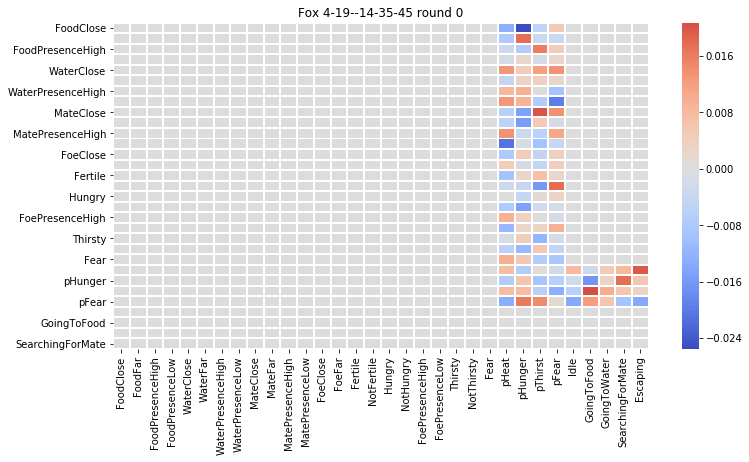

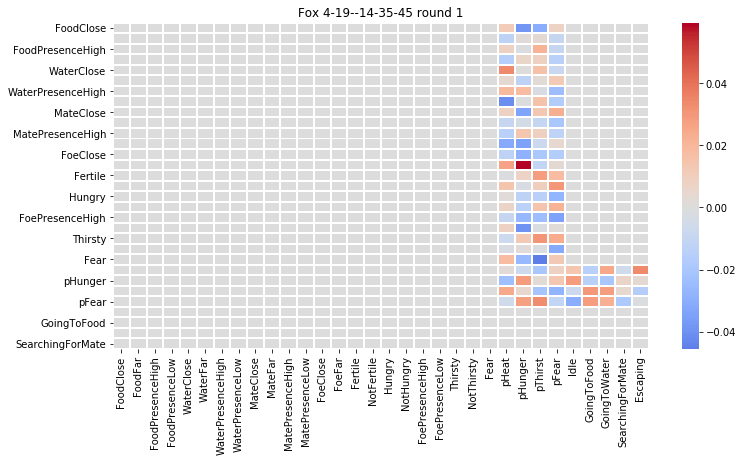

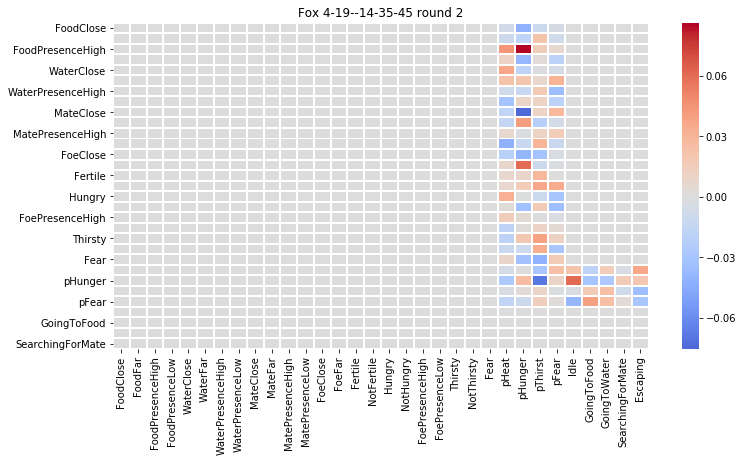

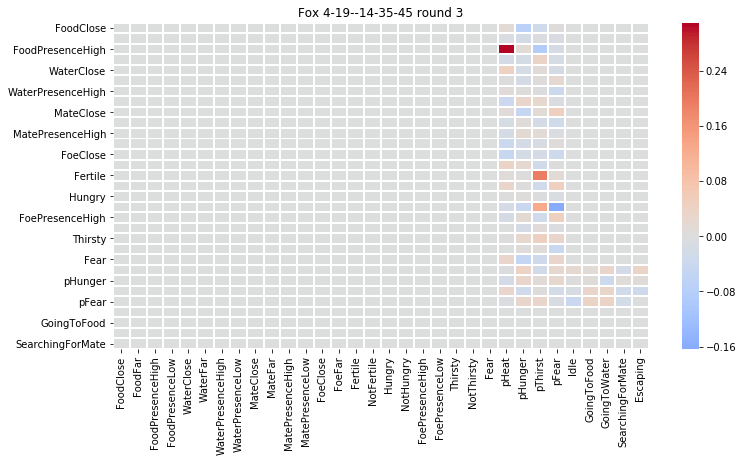

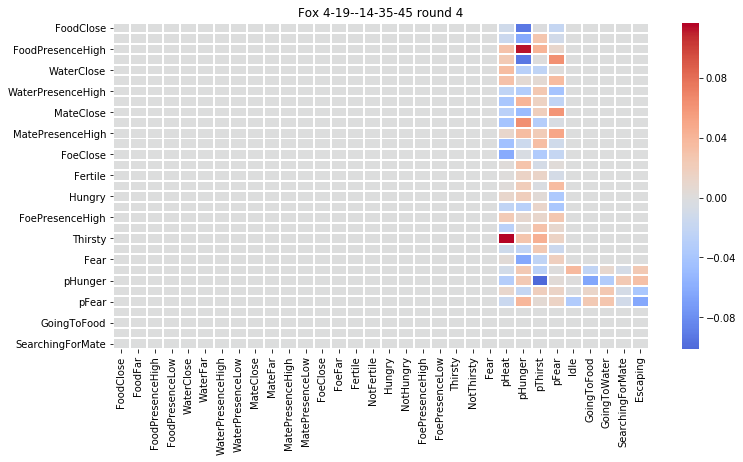

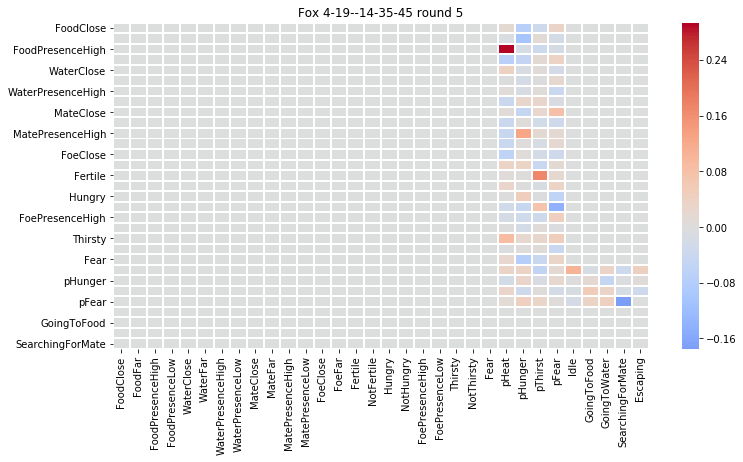

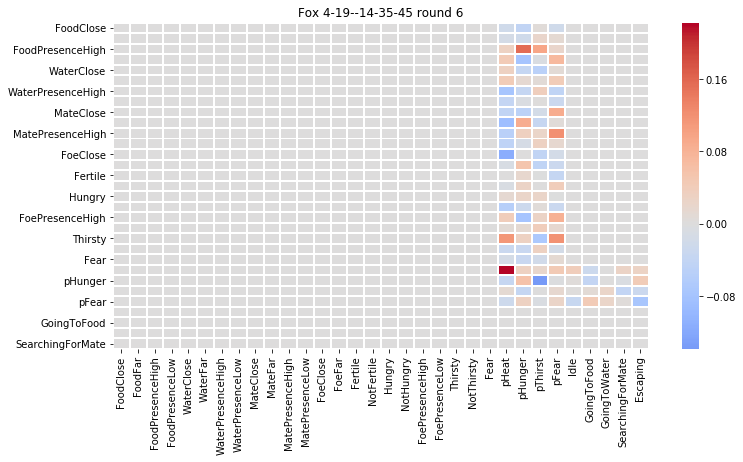

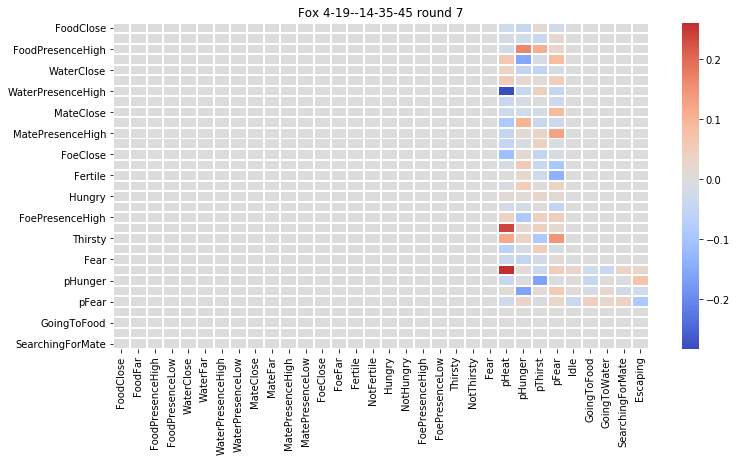

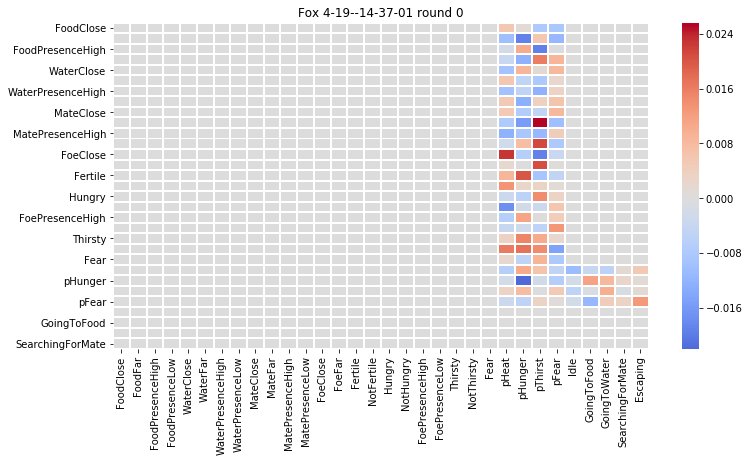

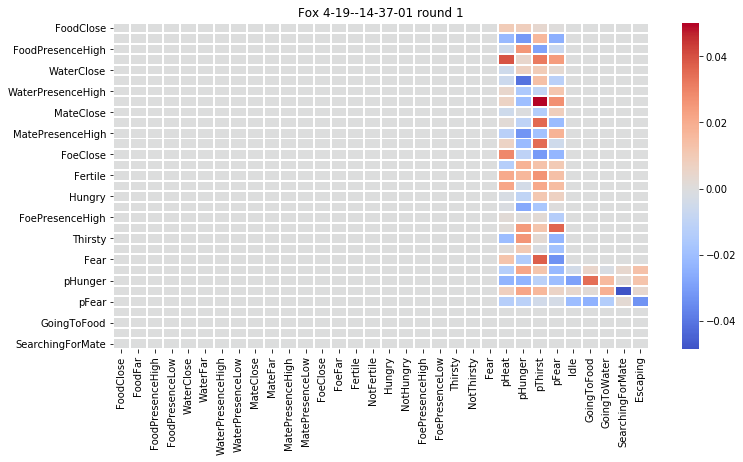

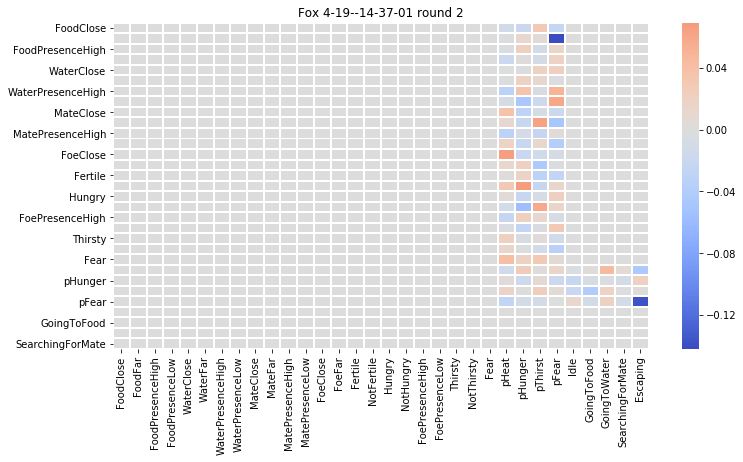

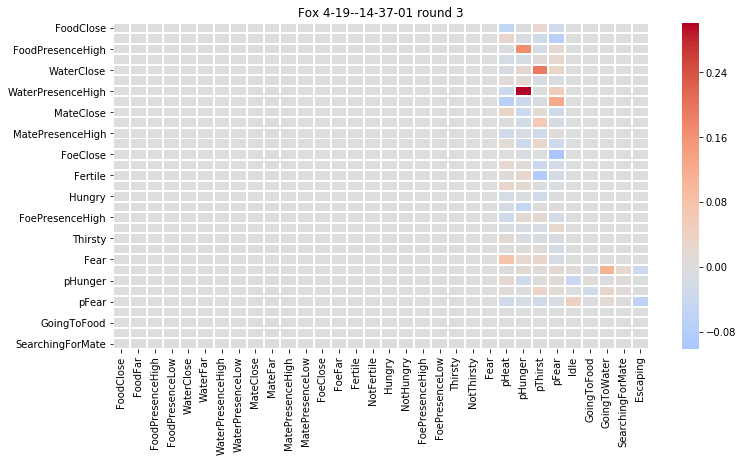

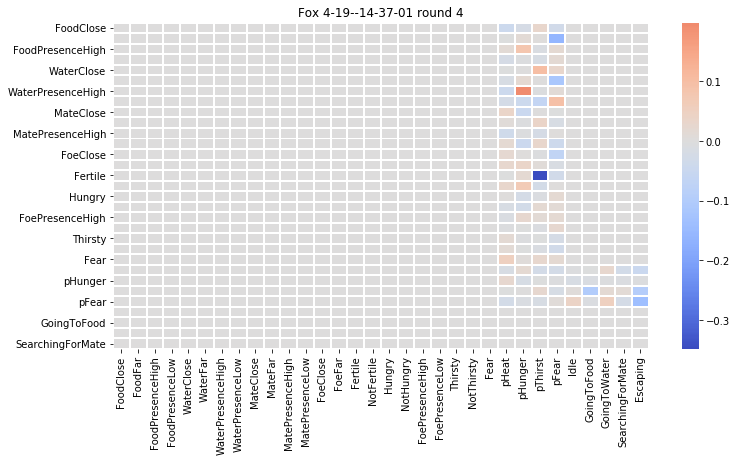

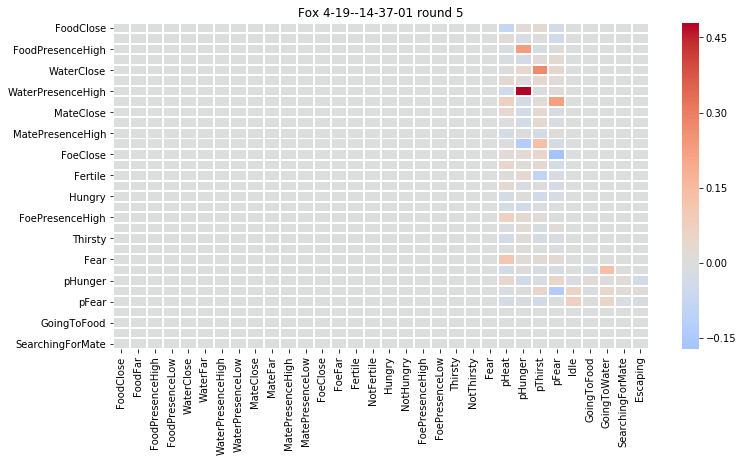

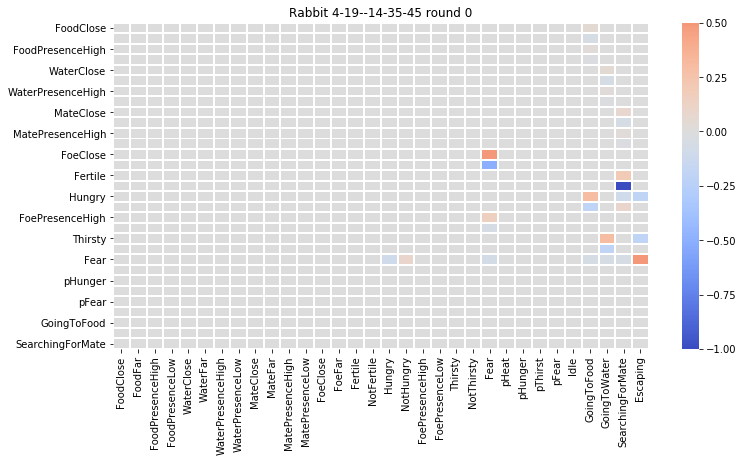

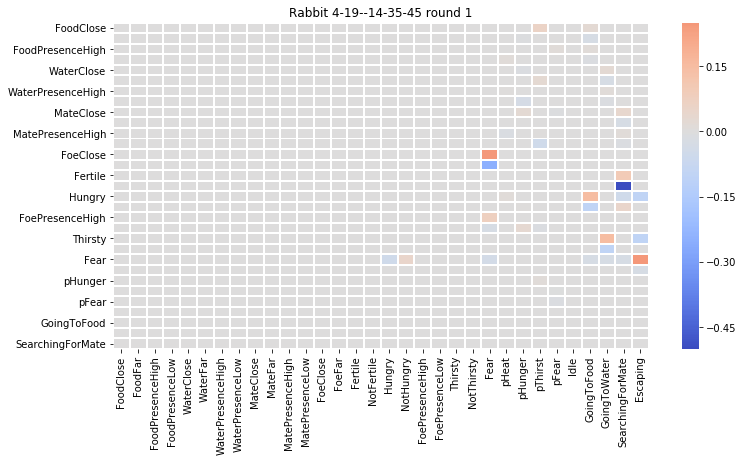

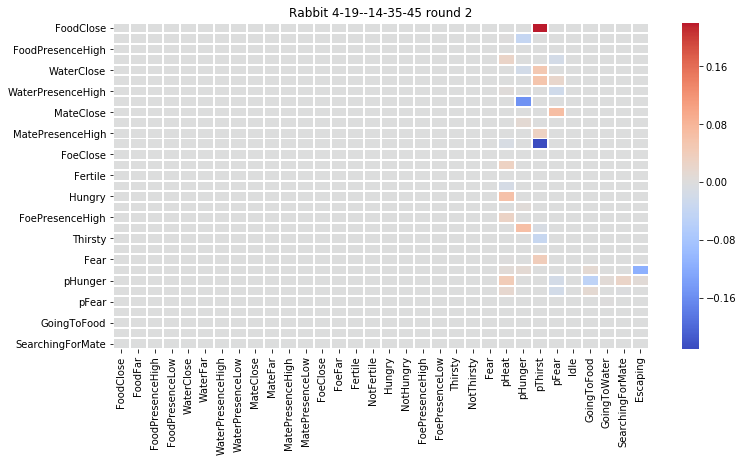

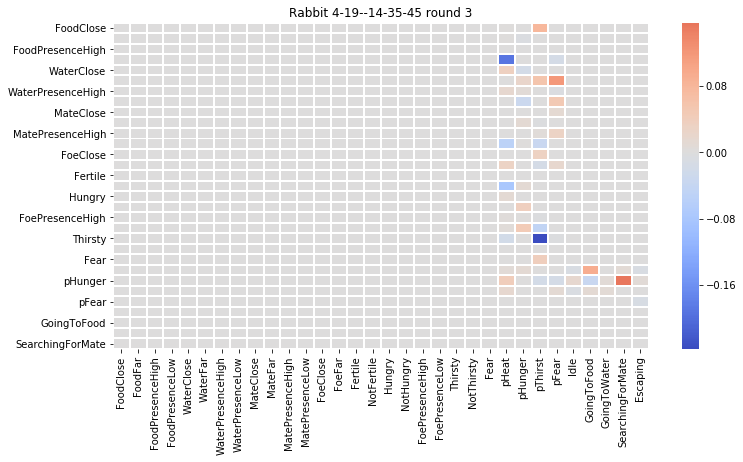

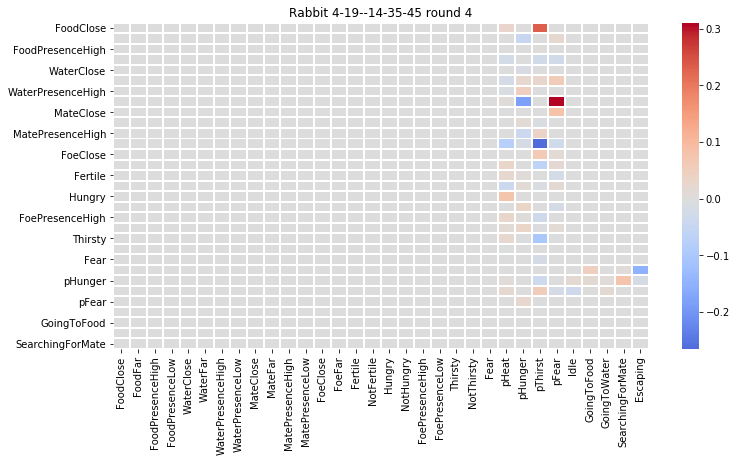

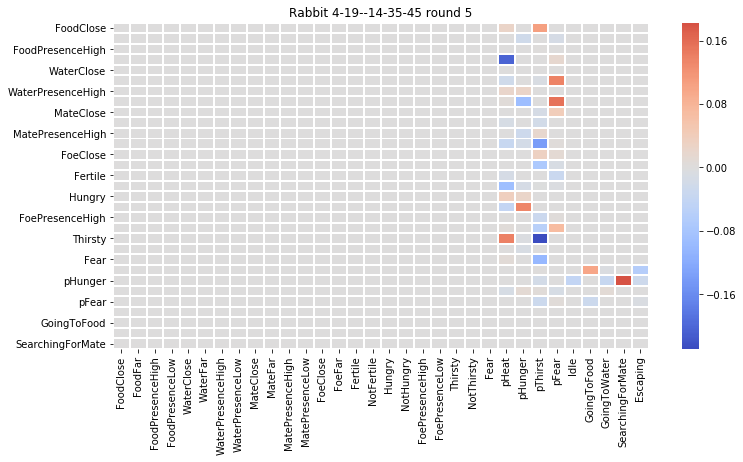

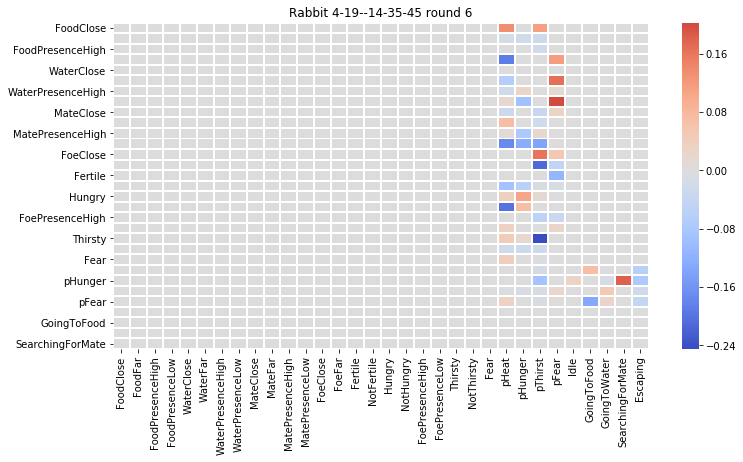

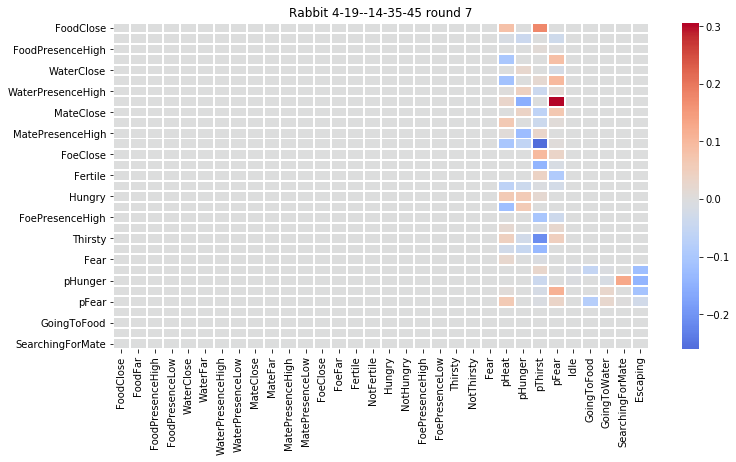

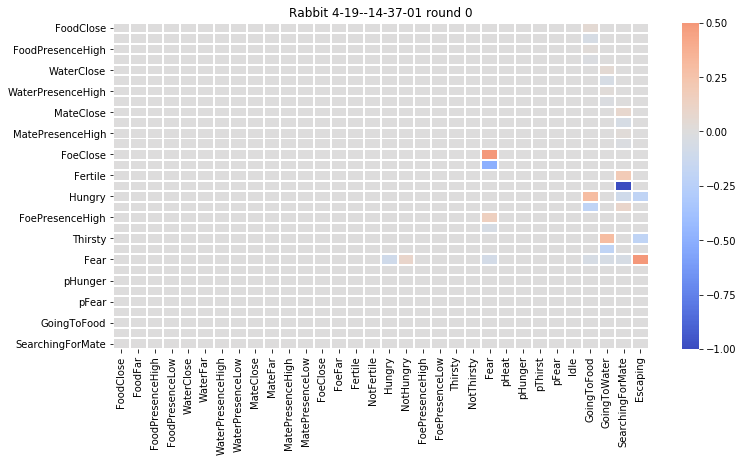

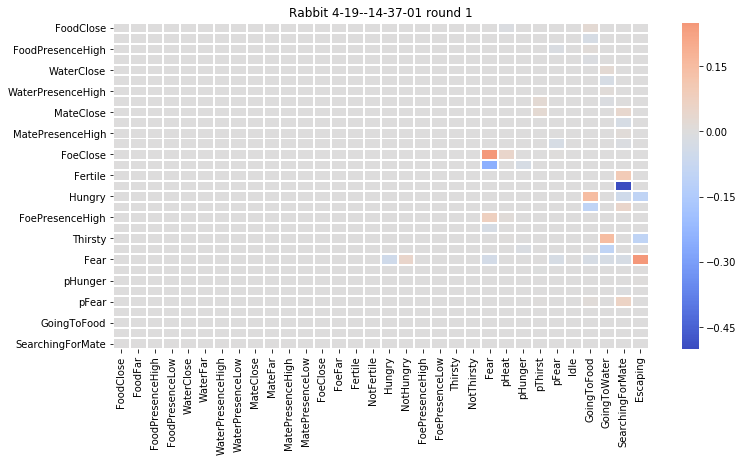

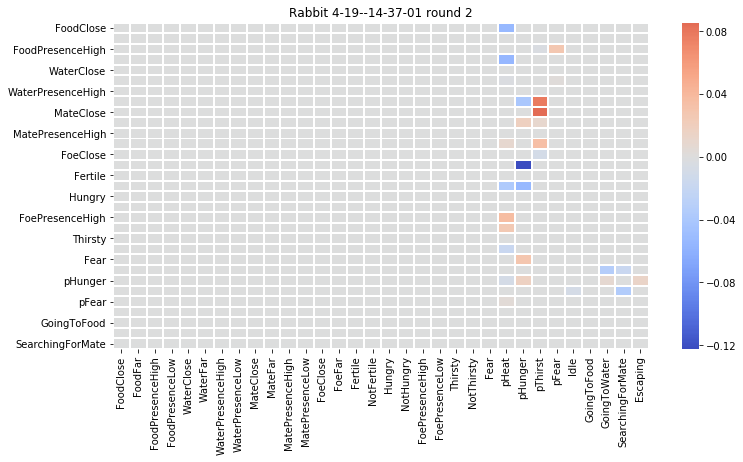

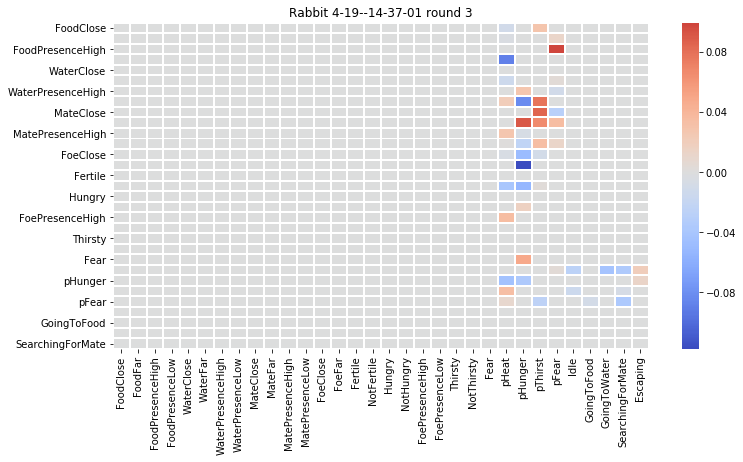

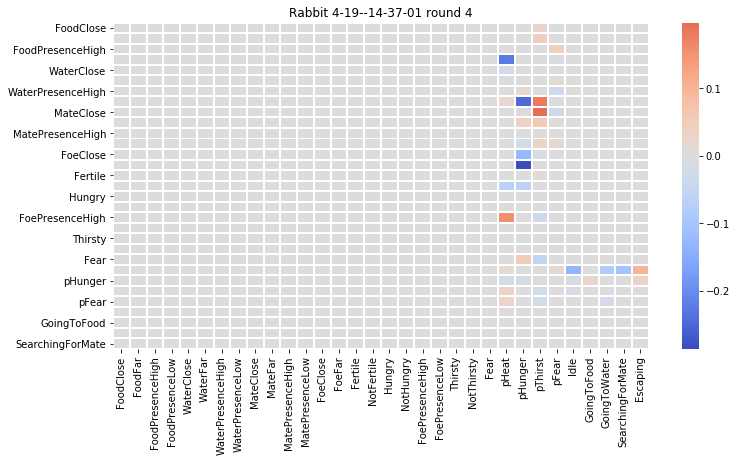

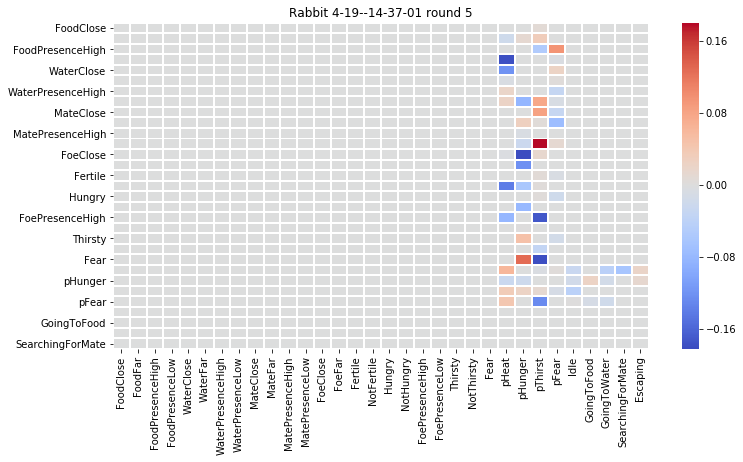

In [6]:

# plot fcm
for s in species: 
    for simulation in fcm_dataframes[s]:
        roundsLeft = True
        round = 0
        while (roundsLeft):
            if round in fcm_dataframes[s][simulation]:
    #for fcm in fcm_dataframes[s]: 
                fig, axes = plt.subplots(figsize = (12, 6))
                #read csv
                data = fcm_dataframes[s][simulation][round]
                #Make it display the fields in the same way as they are listed in EntityField
                data['from'] = pd.Categorical(data['from'], data['from'].unique())
                data['to'] = pd.Categorical(data['to'], data['to'].unique())


                data = data.pivot('from', 'to', 'weight')
                ax = sns.heatmap(data,center=0, linewidth=1, annot=False, cmap="coolwarm")#,vmin=-1, vmax=1)
                plot_title = s + " " + simulation + " round " + str(round)
                ax.set_title(plot_title)
                ax.set_ylabel('')
                ax.set_xlabel('')
                # fix for mpl bug that cuts off top/bottom of seaborn viz
                b, t = ax.get_ylim() # discover the values for bottom and top
                b += 0.5 # Add 0.5 to the bottom
                t -= 0.5 # Subtract 0.5 from the top
                ax.set_ylim([b,t]) # update the ylim(bottom, top) values

                if export:
                    fig.savefig(fcmFolder + "/" + plot_title)

                round = round + 1
            else:
                roundsLeft = False;




In [ ]:
# plot traits grouped by trait and simulation
# Determine how many plots for each trait
maxDataPointsPerPlot = int(200/len(dataframes))
maxDataPoints = 0
for d in dataframes:
    rows = len(d[0].index)
    if rows > maxDataPoints:
        maxDataPoints = rows
        
rest = maxDataPoints
nbrPlotRows = 0
while (rest > 0):
    nbrPlotRows += 1
    rest -= maxDataPointsPerPlot
        
for t in traits:
    fig, axes = plt.subplots(nbrPlotRows, len(dataframes), figsize = (18,4.5*nbrPlotRows))
    fig.get_axes()[0].annotate(t,(0.5,0.95),xycoords='figure fraction', ha='center',fontsize=20)
    counter = 0
    for df in dataframes:
        start = 0
        end = maxDataPointsPerPlot
        length = len(df[0])
        
        ax = None
        legend = []
        for s in species:
            rowCounter = 0
            col = s + '-' + t
            # if e.g Rabbit-speed existed in this simulation, then plot it
            if col in df[0].columns:
                while start < length:
                    # different sub axis indexing depending on nbr of simulations / rows
                    subAx = None
                    if nbrPlotRows == 1 and len(dataframes) == 1:
                            subAx = axes
                    elif nbrPlotRows == 1:
                        subAx = axes[counter]
                    elif len(dataframes) == 1:
                        subAx = axes[rowCounter]
                    else:
                        subAx = axes[rowCounter][counter]
                    ax = df[0].iloc[start:end].plot(kind='line', use_index=True, y=col, grid=True, title=df[1], ax=subAx)
                    rowCounter += 1
                    legend.append(s)
                    ax.set_xlabel("time")
                    ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
                    start = end
                    if (end + maxDataPointsPerPlot > length-1):
                        end = length
                    else:
                        end += maxDataPointsPerPlot
        counter += 1
        # if the the simulation had this trait, then fix legend name
        if len(legend) > 0:
            ax.legend(legend)
    if export:
        fig.savefig(folder + "/" + t)

In [ ]:
"""
# plot fcm
for s in species:
    
    fig, axes = plt.subplots(1,len(dataframes), figsize = (18,6))
    #fig.get_axes()[0].annotate(s,(0.5,0.95),xycoords='figure fraction', ha='center',fontsize=20)
    counter = 0
    for fcm in fcmJsons:

        if fcm[2] == s:
            G = nx.DiGraph(directed=True)
            for entry in fcm[0]['weights']:
                G.add_weighted_edges_from([(entry['from'], entry['to'], entry['weight'])])

            edge_labels=dict([((u,v,),d['weight'])
                             for u,v,d in G.edges(data=True)])

            pos=nx.planar_layout(G)
            nx.draw_networkx(G, pos, arrows=True, arrowsize=20, with_labels=True, node_size=600, font_color='black', ax = axes[counter], title = fcm[1])
            nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10, ax = axes[counter], title = fcm[1])
            axes[counter].set_xticklabels([])
            axes[counter].set_yticklabels([])
            axes[counter].set_title(fcm[1])
            counter += 1
    fig.suptitle(s, y = 0.97, size = 20)
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.87)
    if export:
        fig.savefig(folder + "/" + s)
"""